work with our own image files, real image files such as Jpeg or PNG?
When we end up working with, real image data.

We need to keep in mind the various preprocessing steps that we can perform on the data.

These are steps that deal with things like aspect ratios scaling, normalization of the image, and

then transforming the image to a tensor.

We should also keep in mind that the data sets we saw with Mnist and Cifar contain tens of thousands

of images, and often our real image data sets won't be nearly as large.

However, we already know that we need tens of thousands of images to get robust networks.

So what approaches can we take to try to expand our datasets that don't involve us having to go collect

more new images?

What we can do is we can perform a variety of transformations to expand our data in a clever way.

So let's imagine we have this original image of a dog and maybe we have 1000 of these images, but we

want to increase the actual number of data points we have.

So the number of images, instead of having to go out and take another 1000 photos of dogs, what we

can do is a bunch of transformations on this.

So something we can do is resize and crop the image.

We can also flip the image on a horizontal axis or a vertical axis, if that makes sense for the object

you're trying to scan.

And you can also rotate the image.

So simple transformations like these allow us to greatly increase the number of data points.

Even just performing an additional horizontal flip on all your data points will immediately double the

amount of images you have, as well as make the model more robust to variations on an image.

Since dogs could be facing either to the left or to the right.

It's probably a good idea that you do that horizontal flip on this particular data set and things like

rotations also help out, make the model more robust as well as, again, increasing the number of data

points.

# Loading Real Image Data
So far we've only worked with toy datasets (MNIST, CIFAR-10) conveniently packaged by torchvision, where every image has the same size and shape. Now let's learn the real deal, and work from a varied collection of .jpg files.

For this section we'll be working with a version of the Cats vs. Dogs dataset inspired by a classic <a href='https://www.kaggle.com/c/dogs-vs-cats'>Kaggle competition</a>.<br>
A quick note - do <strong>not</strong> download the dataset from Kaggle! Ours is a cleaned version of the data without any 0by0 files, etc.<br>The images are similar to ones available from the <a href='http://www.image-net.org/'>ImageNet</a> database.

We have organized the files into train and test folders, and further divided the images into CAT and DOG subfolders. In this way the file path contains the label.

### Image files directory tree
<pre>.
└── Data
    └── CATS_DOGS
        ├── test
        │   ├── CAT
        │   │   ├── 9374.jpg
        │   │   ├── 9375.jpg
        │   │   └── ... (3,126 files)
        │   └── DOG
        │       ├── 9374.jpg
        │       ├── 9375.jpg
        │       └── ... (3,125 files)       
        │           
        └── train
            ├── CAT
            │   ├── 0.jpg
            │   ├── 1.jpg
            │   └── ... (9,371 files)
            └── DOG
                ├── 0.jpg
                ├── 1.jpg
                └── ... (9,372 files)</pre>

## Perform standard imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Examine the data
We'll us Python's built-in <a href='https://docs.python.org/3/library/os.html'>os module</a> to walk the directories collecting file names. We'll then use <a href='https://python-pillow.org/'>Pillow</a>, an extension to the Python Imaging Library (PIL), to open image files and extract image sizes. A pandas DataFrame will provide summary statistics on our data like max/min width & height from which we can choose our model parameters.

In [3]:
import os
from PIL import Image
from IPython.display import display

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

<div class="alert-danger"><strong>NOTE: </strong>There's a <a href='https://github.com/python-pillow/Pillow/issues/3769'>known issue</a> with <strong>Pillow v6.0.0</strong> where it cannot open certain .jpg files, and instead raises an<br>
<tt><strong>UnboundLocalError: </strong>local variable 'photoshop' referenced before assignment</tt><br>This is due to be fixed in an upcoming release.
    
For example, the images affected in the CAT test set are:
<pre style='background-color:rgb(242,222,222)'>['../Data/CATS_DOGS/test/CAT/10107.jpg',
 '../Data/CATS_DOGS/test/CAT/10404.jpg',
 '../Data/CATS_DOGS/test/CAT/12086.jpg',
 '../Data/CATS_DOGS/test/CAT/9493.jpg',
 '../Data/CATS_DOGS/test/CAT/9683.jpg']</pre>

If this happens, you can either install an older version of Pillow, or use our pytorch_course_env.yml file.</div>

In [4]:
pwd

'/content'

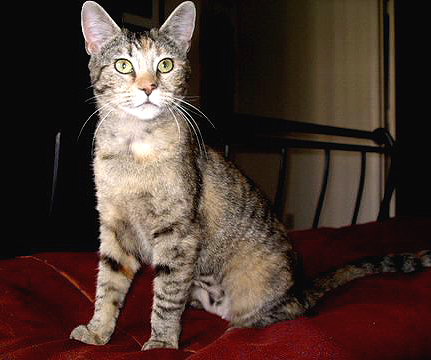

In [5]:
# TEST YOUR VERSION OF PILLOW
# Run this cell. If you see a picture of a cat you're all set!
with Image.open('./drive/MyDrive/Colab Notebooks/CatsDogs/test/CAT/10000.jpg') as im:
    display(im)

### Create a list of image filenames

In [6]:
path = './drive/MyDrive/Colab Notebooks/CatsDogs/'

next(os.walk(path))

('./drive/MyDrive/Colab Notebooks/CatsDogs/', ['train', 'test'], [])

In [7]:
#path = '..\\Data\\CATS_DOGS\\'

#path = '.\\drive\\MyDrive\\Colab Notebooks\\CatsDogs\\'
path = './drive/MyDrive/Colab Notebooks/CatsDogs/'

img_names = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)

print('Images: ',len(img_names))

Images:  23597


In [8]:
dog_images_train = img_names[1:101]
cat_images_train = img_names[10001:10101]

In [9]:
dog_images_test = img_names[20001:20031]
cat_images_test =img_names[22001:22031]

In [10]:
img_names[:5]

['./drive/MyDrive/Colab Notebooks/CatsDogs/train/DOG/8559.jpg',
 './drive/MyDrive/Colab Notebooks/CatsDogs/train/DOG/8494.jpg',
 './drive/MyDrive/Colab Notebooks/CatsDogs/train/DOG/849.jpg',
 './drive/MyDrive/Colab Notebooks/CatsDogs/train/DOG/8570.jpg',
 './drive/MyDrive/Colab Notebooks/CatsDogs/train/DOG/8520.jpg']

### Create a DataFrame of image sizes (width x height)
It's worth noting that <tt>Image.open()</tt> doesn't read the entire image into memory, so it's a reasonable way to get image sizes.<br>
Still, this can take awhile.

In [11]:
new_img= [] #taking less number of images
new_img.extend(dog_images_train)
new_img.extend(cat_images_train)
new_img.extend(dog_images_test)
new_img.extend(cat_images_test)
#new_img

In [12]:
# Start by creating a list
img_sizes = []
rejected = []

for item in new_img:
    try:
        with Image.open(item) as img:
            #print(img.size) # (500, 375)
            #break
            img_sizes.append(img.size)
    except:
        rejected.append(item)

print(f'Images:  {len(img_sizes)}')
print(f'Rejects: {len(rejected)}')

Images:  260
Rejects: 0


In [ ]:
# Start by creating a list
img_sizes = []
rejected = []

for item in img_names:
    try:
        with Image.open(item) as img:
            #print(img.size) # (500, 375)
            #break
            img_sizes.append(img.size)
    except:
        rejected.append(item)

print(f'Images:  {len(img_sizes)}')
print(f'Rejects: {len(rejected)}')

In [ ]:
# Start by creating a list
img_sizes = []
rejected = []

for item in img_names:
    try:
        with Image.open(item) as img:
            #print(img.size) # (500, 375)
            #break
            img_sizes.append(img.size)
    except:
        rejected.append(item)

print(f'Images:  {len(img_sizes)}')
print(f'Rejects: {len(rejected)}')

In [41]:
img_sizes[:5]

[(259, 419), (500, 375), (60, 50), (288, 250), (360, 270)]

In [ ]:
# Convert the list to a DataFrame
df = pd.DataFrame(img_sizes)

# Run summary statistics on image widths
df[0].describe()

count    23597.000000
mean       404.826842
std        108.909596
min         42.000000
25%        324.000000
50%        448.000000
75%        500.000000
max        500.000000
Name: 0, dtype: float64

In [ ]:
# Run summary statistics on image heights
df[1].describe()

count    24994.000000
mean       361.037129
std         96.936811
min         33.000000
25%        302.000000
50%        375.000000
75%        421.000000
max        500.000000
Name: 1, dtype: float64

This tells us the shortest width is 42, the shortest height is 33, the largest width and height are 500, and that most images have more than 300 pixels per side. This is useful for deciding on an input size. We'll see in the next section that 224x224 will work well for our purposes (we'll take advantage of some pre-trained models that use this size!)

## Image Preprocessing
# important
Any network we define requires consistent input data. That is, the incoming image files need to have the same number of channels (3 for red/green/blue), the same depth per channel (0-255), and the same height and width as the input for predefined models. This last requirement can be tricky. How do we transform an 800x450 pixel image into one that is 224x224? In the theory lectures we covered the following:
Also the mean and standard deviation of normalized values should match with the predefined models values.

* <a href='https://en.wikipedia.org/wiki/Aspect_ratio_(image)'><strong>aspect ratio</strong></a>: the ratio of width to height (16:9, 1:1, etc.) An 800x450 pixel image has an aspect ration of 16:9. We can change the aspect ratio of an image by cropping it, by stretching/squeezing it, or by some combination of the two. In both cases we lose some information contained in the original. Let's say we crop 175 pixels from the left and right sides of our 800x450 image, resulting in one that's 450x450.
* <strong>scale</strong>: Once we've attained the proper aspect ratio we may need to scale an image up or down to fit our input parameters. There are several libraries we can use to scale a 450x450 image down to 224x224 with minimal loss.
* <a href=''><strong>normalization</strong></a>: when images are converted to tensors, the [0,255] rgb channels are loaded into range [0,1]. We can then normalize them using the generally accepted values of mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. For the curious, these values were obtained by the PyTorch team using a random 10,000 sample of <a href='http://www.image-net.org/'>ImageNet</a> images. There's a good discussion of this <a href='https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/22'>here</a>, and the original source code can be found <a href='https://github.com/soumith/imagenet-multiGPU.torch/blob/master/donkey.lua#L154'>here</a>.

## Transformations
Before defining our Convolutional Network, let's look at a sample image and perform various transformations on it to see their effect.

(500, 387)


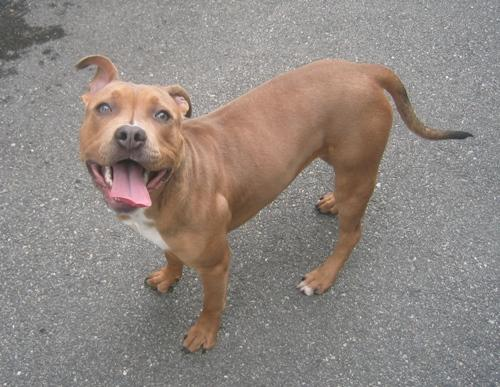

In [13]:
dog = Image.open('./drive/MyDrive/Colab Notebooks/CatsDogs/train/DOG/14.jpg')
print(dog.size)
display(dog)

This is how jupyter displays the original .jpg image. Note that size is given as (width, height).<br>
Let's look at a single pixel:

In [14]:
r, g, b = dog.getpixel((0, 0))
print(r,g,b)

90 95 98


The pixel at position [0,0] (upper left) of the source image has an rgb value of (90,95,98). This corresponds to <font style="background-color:rgb(90,95,98)">this color </font><br>
Great! Now let's look at some specific transformations.
### <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ToTensor'><tt>transforms.ToTensor()</tt></a>
Converts a PIL Image or numpy.ndarray (HxWxC) in the range [0, 255] to a <tt>torch.FloatTensor</tt> of shape (CxHxW) in the range [0.0, 1.0]

torch.Size([3, 387, 500])


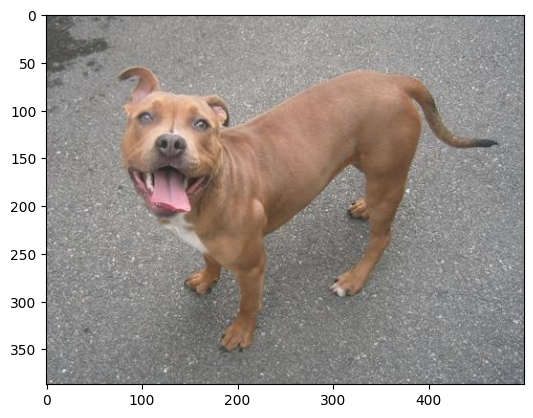

In [15]:
transform = transforms.Compose([
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0))); # to convert to 387,500,3 shape

This is the same image converted to a tensor and displayed using matplotlib. Note that the torch dimensions follow [channel, height, width]<br><br>
PyTorch automatically loads the [0,255] pixel channels to [0,1]:<br><br>
$\frac{90}{255}=0.3529\quad\frac{95}{255}=0.3725\quad\frac{98}{255}=0.3843$

In [47]:
im[:,0,0]

tensor([0.3529, 0.3725, 0.3843])

### <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Resize'><tt>transforms.Resize(<em>size</em>)</tt></a>
If size argument is a sequence like (h, w), the output size will be matched to this. If size is an integer, the smaller edge of the image will be matched to this number.<br>i.e, if height > width, then the image will be rescaled to (size * height / width, size)

In [16]:
im.size()

torch.Size([3, 387, 500])

In [17]:
224*500/387

289.405684754522

torch.Size([3, 224, 289])


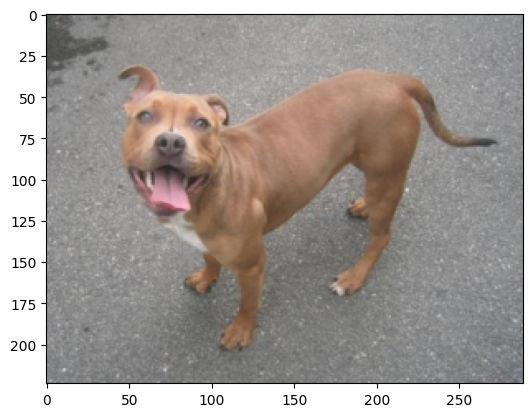

In [19]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

This resized the shortest side, and scaled the other. Let's try this on a small image.

(135, 102)


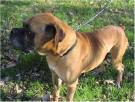

In [20]:
small_dog = Image.open('./drive/MyDrive/Colab Notebooks/CatsDogs/train/DOG/11.jpg')
print(small_dog.size)
display(small_dog)

In [21]:
224*135/102

296.47058823529414

torch.Size([3, 224, 296])


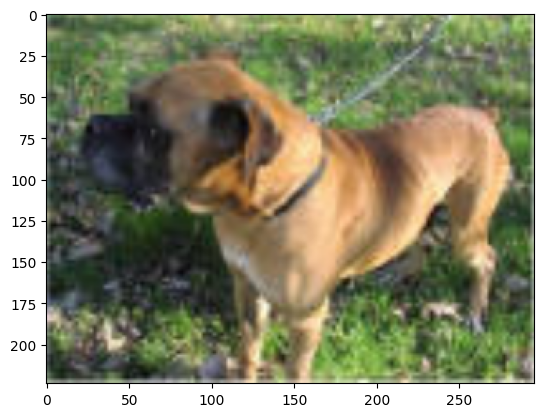

In [22]:
im = transform(small_dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.CenterCrop'><tt>transforms.CenterCrop(<em>size</em>)</tt></a>
If size is an integer instead of sequence like (h, w), a square crop of (size, size) is made.

(500, 387)
torch.Size([3, 224, 224])


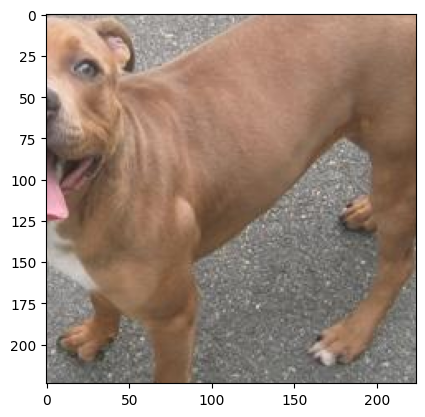

In [23]:
transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor()
])
print(dog.size)
im = transform(dog) # this crops the original image
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

It may be better to resize the image first, then crop:

(500, 387)
torch.Size([3, 224, 224])


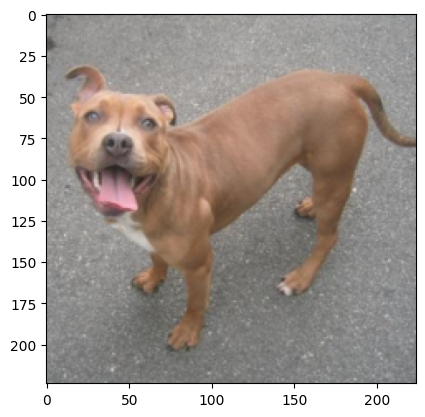

In [24]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])
print(dog.size)

im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Other affine transformations
An <a href='https://en.wikipedia.org/wiki/Affine_transformation'><em>affine</em></a> transformation is one that preserves points and straight lines. Examples include rotation, reflection, and scaling. For instance, we can double the effective size of our training set simply by flipping the images.
### <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomHorizontalFlip'><tt>transforms.RandomHorizontalFlip(<em>p=0.5</em>)</tt></a>
Horizontally flip the given PIL image randomly with a given probability.

torch.Size([3, 387, 500])


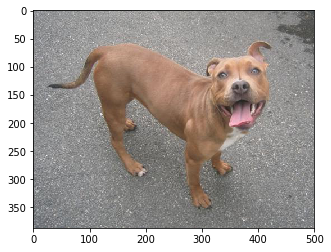

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),  # normally we'd set p=0.5
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomRotation'><tt>transforms.RandomRotation(<em>degrees</em>)</tt></a>
If degrees is a number instead of sequence like (min, max), the range of degrees will be (-degrees, +degrees).<br>
Run the cell below several times to see a sample of rotations.

torch.Size([3, 387, 500])


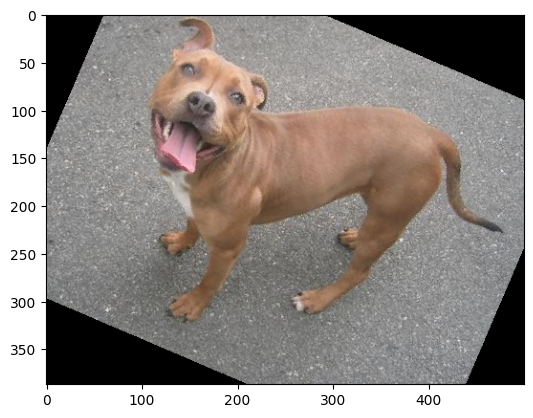

In [25]:
transform = transforms.Compose([
    transforms.RandomRotation(30),  # rotate randomly between +/- 30 degrees
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### Scaling is done using <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Resize'><tt>transforms.Resize(<em>size</em>)</tt></a>

torch.Size([3, 224, 224])


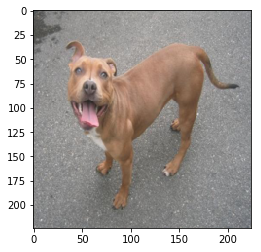

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),  # be sure to pass in a list or a tuple
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Let's put it all together

torch.Size([3, 224, 224])


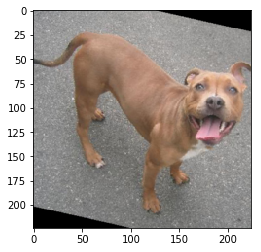

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),  # normally we'd set p=0.5
    transforms.RandomRotation(30),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

___
## Normalization
But sometimes you load up a pre-trained network and has very specific means and standard deviations. And there's actually a lot of research that has experimented with a lot of these values.

Once the image has been loaded into a tensor, we can perform normalization on it. This serves to make convergence happen quicker during training. The values are somewhat arbitrary - you can use a mean of 0.5 and a standard deviation of 0.5 to convert a range of [0,1] to [-1,1], for example.<br>However, <a href='https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/22'>research has shown</a> that mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] work well in practice.

### <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize'><tt>transforms.Normalize(<em>mean, std</em>)</tt></a>
Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels, this transform will normalize each channel of the input tensor
### $\quad\textrm {input[channel]} = \frac{\textrm{input[channel] - mean[channel]}}{\textrm {std[channel]}}$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 387, 500])


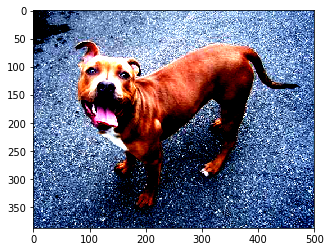

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

Recall that before normalization, the upper-leftmost tensor had pixel values of <tt>[0.3529, 0.3725, 0.3843]</tt>.<br>
With normalization we subtract the channel mean from the input channel, then divide by the channel std.<br><br>
$\frac{(0.3529-0.485)}{0.229}=-0.5767\quad\frac{(0.3725-0.456)}{0.224}=-0.3725\quad\frac{(0.3843-0.406)}{0.225}=-0.0964$<br>

In [ ]:
# After normalization:
im[:,0,0]

tensor([-0.5767, -0.3725, -0.0964])

When displayed, matplotlib clipped this particular pixel up to [0,0,0] so it appears black on the screen. However, the appearance isn't important; the goal of normalization is improved mathematical performance.

### Optional: De-normalize the images
To see the image back in its true colors, we can apply an inverse-transform to the tensor being displayed.

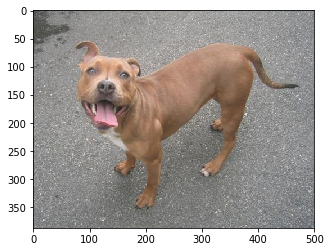

In [ ]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

Note that the original tensor was not modified:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


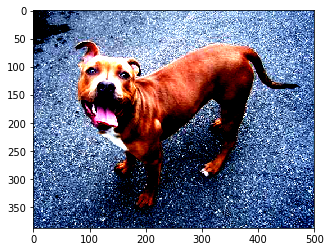

In [ ]:
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));